In [18]:
import sys
import pickle
import random
import matplotlib.pyplot as plt

import torch
import torch.nn as nn

from torch.utils.data import DataLoader

from pathlib import Path

HOME = Path.cwd().parent
sys.path.append(str(HOME))

In [19]:
with open(HOME / 'cache/transfer.pkl', 'rb') as f:
    mat2bat = pickle.load(f)

In [20]:
class Dataset:
    def __init__(self, feature, label):
        self.feature = feature
        self.label = label

    def __len__(self):
        return len(self.label)

    def __getitem__(self, indx: int):
        return self.feature[indx], self.label[indx]

    def __iter__(self):
        for i in range(len(self)):
            yield self[i]

    def to(self, device):
        self.feature = self.feature.to(device)
        self.label = self.label.to(device)
        return self

    @property
    def device(self):
        return self.label.device


class DatasetWithSupport(Dataset):
    def __init__(self, feature, label, support_feat, support_label, support_size: int = 8):
        self.feature = feature
        self.label = label
        self.support_feature = support_feat
        self.support_label = support_label
        self.support_size = support_size

    def __getitem__(self, i: int):
        feat, label = self.feature[i], self.label[i]
        index = random.sample(range(self.support_label.shape[1]), self.support_size)
        sup_feat, sup_label = self.support_feature[i, index], self.support_label[i, index]
        return feat, label, sup_feat, sup_label

    def to(self, device):
        self.feature = self.feature.to(device)
        self.label = self.label.to(device)
        self.support_feature = self.support_feature.to(device)
        self.support_label = self.support_label.to(device)
        return self

In [21]:
class ZscoreProcessor:
    def __init__(
        self,
        label_mean: float | None = None,
        label_std: float | None = None
    ):
        self.label_mean = label_mean
        self.label_std = label_std

    def fit(self, label):
        label = label.float().log()
        if len(label) == 1:
            self.label_mean, self.label_std = label.item(), 1.
        else:
            self.label_mean = torch.mean(label).item()
            self.label_std = torch.std(label).item()

    def transform(self, label):
        label = label.float().log()
        label = (label - self.label_mean) / self.label_std
        return label

    def inverse_transform(self, label):
        label = label * self.label_std + self.label_mean
        return label.exp()


class FeatureSmoother:
    def __init__(self, ths: float = 5.):
        self.ths = ths

    def transform(self, feature):
        feature[feature.abs() > self.ths] = 0.
        return feature


class DiffCurveCalculator:
    def __init__(self, diff_cycle: int = 9, ths: float = 10.):
        self.diff_cycle = diff_cycle
        self.smoother = FeatureSmoother(ths)

    def transform(self, feature, support_feature=None):
        cycle_diff = feature - feature[:, :, [self.diff_cycle]]
        cycle_diff = self.smoother.transform(cycle_diff)
        if support_feature is not None:
            cell_diff = feature[:, None] - support_feature[None]
            cell_diff = self.smoother.transform(cell_diff)
            return cycle_diff, cell_diff
        return cycle_diff

In [22]:
class ConvModule(nn.Module):
    def __init__(self, din, dout, kernel_size,
                 act_fn: str = 'relu',
                 dropout: float = 0.1):
        nn.Module.__init__(self)
        self.kernel_size = kernel_size
        self.conv1 = nn.Conv2d(din, dout, kernel_size)
        self.pool1 = nn.AvgPool2d(kernel_size)
        self.conv2 = nn.Conv2d(dout, dout, kernel_size)
        self.pool2 = nn.AvgPool2d(kernel_size)
        self.act_fn = getattr(torch, act_fn)
        self.dropout = nn.Dropout2d(dropout)

    def output_shape(self, H, W):
        # conv1 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool1 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)
        # conv2 output
        H, W = H - self.kernel_size[0] + 1, W - self.kernel_size[1] + 1
        # pool2 output
        H = int((H - self.kernel_size[0]) / self.kernel_size[0] + 1)
        W = int((W - self.kernel_size[1]) / self.kernel_size[1] + 1)

        return H, W

    def forward(self, x):
        x = self.conv1(x)
        x = self.act_fn(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act_fn(x)
        x = self.pool2(x)

        return x


class CNNRULPredictor(nn.Module):
    def __init__(self,
                 in_channels: int,
                 channels: int,
                 input_height: int,
                 input_width: int,
                 kernel_size=3,
                 act_fn: str = 'relu'):
        nn.Module.__init__(self)
        self.channels = channels
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if input_height < kernel_size[0]:
            kernel_size = (input_height, kernel_size[1])
        if input_width < kernel_size[1]:
            kernel_size = (kernel_size[0], input_width)
        self.encoder = ConvModule(in_channels, channels, kernel_size, act_fn)
        H, W = self.encoder.output_shape(input_height, input_width)
        self.proj = nn.Conv2d(channels, channels, (H, W))
        self.fc = nn.Linear(channels, 1)

    def forward(self, feature: torch.Tensor):
        x = self.encoder(feature)
        x = self.proj(x)
        x = x.view(-1, self.channels)
        x = torch.relu(x)
        x = self.fc(x).view(-1)

        return x


class BatLiNetRULPredictor(nn.Module):
    def __init__(
        self,
        in_channels: int,
        channels: int,
        input_height: int,
        input_width: int,
        kernel_size: int = 3,
        alpha: float = 0.5,
        act_fn: str = 'relu',
        use_seperate_bias: bool = True
    ):
        nn.Module.__init__(self)
        self.channels = channels
        if isinstance(kernel_size, int):
            kernel_size = (kernel_size, kernel_size)
        if input_height < kernel_size[0]:
            kernel_size = (input_height, kernel_size[1])
        if input_width < kernel_size[1]:
            kernel_size = (kernel_size[0], input_width)

        self.ori_enc = ConvModule(in_channels, channels, kernel_size, act_fn)
        H, W = self.ori_enc.output_shape(input_height, input_width)
        self.ori_proj = nn.Conv2d(channels, channels, (H, W))
        self.sup_enc = ConvModule(in_channels, channels, kernel_size, act_fn)
        self.sup_proj = nn.Conv2d(channels, channels, (H, W))
        self.fc = nn.Linear(channels, 1, bias=False)
        self.w1 = nn.Parameter(torch.tensor(0.))
        self.w2 = nn.Parameter(torch.tensor(0.))
        self.use_seperate_bias = use_seperate_bias
        self.alpha = alpha

    def forward(
        self,
        feature: torch.Tensor,
        diff_feature: torch.Tensor,
    ):
        B, S, C, H, W = diff_feature.size()

        x_ori = torch.relu(self.ori_proj(self.ori_enc(feature)))
        x_sup = torch.relu(self.sup_proj(self.sup_enc(diff_feature.view(-1, C, H, W))))

        y_ori = self.fc(x_ori.view(len(feature), self.channels)).view(-1)
        y_sup = self.fc(x_sup.view(B * S, self.channels)).view(B, S)

        if self.use_seperate_bias:
            y_ori += self.w1
            y_sup += self.w2

        return y_ori, y_sup

def mape(x, y):
    x, y = torch.tensor(x), torch.tensor(y)
    return torch.mean((x - y).abs() / y)

In [37]:
support_feat = torch.stack([x.feature for x in mat2bat['LFP'] if 500 < x.label < 2500]).float()
support_label = torch.stack([x.label for x in mat2bat['LFP'] if 500 < x.label < 2500]).float()
nca_feat = torch.stack([x.feature for x in mat2bat['NMC']]).float()
nca_label = torch.stack([x.label for x in mat2bat['NMC']]).float()

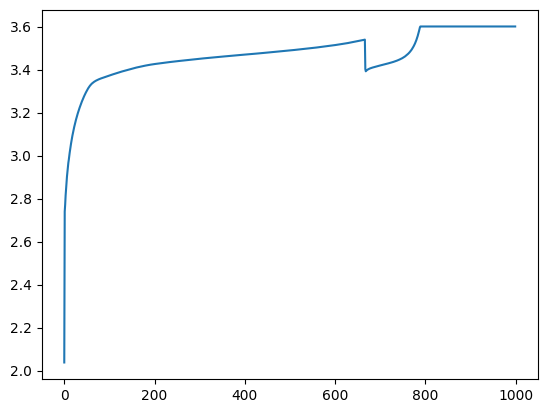

In [51]:
plt.plot(support_feat[0][0][3])

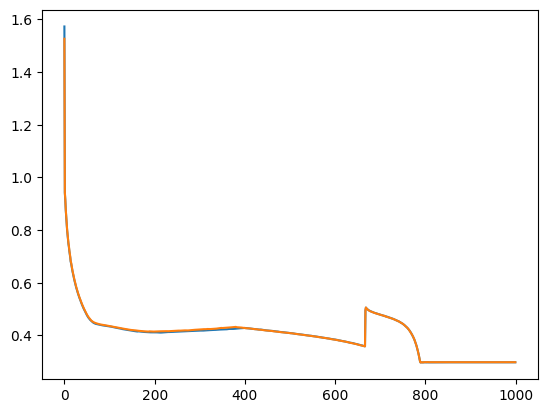

In [56]:
plt.plot(nca_feat[0, 0, 3] - support_feat[0, 0, 3])
plt.plot(nca_feat[4, 0, 3] - support_feat[0, 0, 3])
plt.show()

In [31]:
N = 16

differ = DiffCurveCalculator()
zscorer = ZscoreProcessor()
zscorer.fit(nca_label[:N])

model = CNNRULPredictor(6, 32, 100, 1000)

# Prepare the data for training and testing
data_train = Dataset(differ.transform(nca_feat[:N]), zscorer.transform(nca_label[:N]))
data_test = Dataset(differ.transform(nca_feat[N:]), nca_label[N:])

model = model.to(0)
data_train = data_train.to(0)
data_test = data_test.to(0)

# Create data loaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = DataLoader(data_test, batch_size=32, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 200
for epoch in range(num_epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 10 == 0:
        # Evaluate the model on the test data
        model.eval()
        with torch.no_grad():
            ans, labels = [], []
            for inputs, label in test_loader:
                outputs = model(inputs)
                outputs = zscorer.inverse_transform(outputs)
                ans.extend(outputs.cpu().tolist())
                labels.extend(label.cpu().tolist())
            print('Eval MAPE:', mape(ans, labels), ans, labels)

Epoch [1/200], Loss: 0.9420
Epoch [2/200], Loss: 1.0001
Epoch [3/200], Loss: 0.9271
Epoch [4/200], Loss: 0.9654
Epoch [5/200], Loss: 0.9458
Epoch [6/200], Loss: 0.9310
Epoch [7/200], Loss: 0.9236
Epoch [8/200], Loss: 0.9197
Epoch [9/200], Loss: 0.9140
Epoch [10/200], Loss: 0.9040
Eval MAPE: tensor(0.4853) [687.4338989257812, 688.27587890625, 687.083251953125, 688.5667114257812, 688.8724365234375, 691.1578369140625, 689.3975830078125, 689.66064453125, 686.5972290039062, 686.197265625, 687.7069702148438, 689.2305908203125, 690.2511596679688, 691.2164916992188, 689.7747192382812, 692.084228515625, 688.5072631835938, 689.279541015625, 690.7885131835938, 689.2720336914062, 688.9929809570312, 691.0689086914062, 689.4981689453125, 692.10107421875, 687.9893798828125, 691.37744140625, 691.2814331054688, 689.736572265625, 687.6867065429688, 688.9069213867188, 688.505615234375, 691.087646484375, 689.3890380859375, 682.9193115234375, 702.8140258789062, 699.7612915039062, 687.382080078125, 688.2942

In [25]:
N = 8

differ = DiffCurveCalculator()
zscorer = ZscoreProcessor()

model = BatLiNetRULPredictor(6, 32, 100, 1000)

# Prepare the data for training and testing
train_feat, diff_feat = differ.transform(nca_feat[:N], support_feat)
test_feat, diff_feat = differ.transform(nca_feat[N:], support_feat)
zscorer.fit(nca_label[:N])
train_label, norm_sup_label = zscorer.transform(nca_label[:N]), zscorer.transform(support_label)
diff_label = train_label[:, None] - norm_sup_label[None]
data_train = DatasetWithSupport(train_feat, train_label, diff_feat, diff_label)
data_test = DatasetWithSupport(
    test_feat,
    nca_label[N:],
    diff_feat,
    norm_sup_label[None].expand(
        len(nca_label[N:]),
        *norm_sup_label.shape
    ),
    8
)

device = 7

model = model.to(device)
data_train = data_train.to(device)
data_test = data_test.to(6)

# Create data loaders
train_loader = DataLoader(data_train, batch_size=32, shuffle=True)
test_loader = DataLoader(data_test, batch_size=1, shuffle=False)

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    for inputs, labels, sup_inputs, sup_labels in train_loader:
        optimizer.zero_grad()
        y1, y2 = model(inputs, sup_inputs)
        loss = 0.2 * criterion(y1, labels.view(-1)) + 0.8 * criterion(y2.view(-1), sup_labels.view(-1))
        loss.backward()
        optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
    if (epoch + 1) % 10 == 0:
        # Evaluate the model on the test data
        model.eval()
        with torch.no_grad():
            ans, labels = [], []
            model = model.to(data_test.device)
            for inputs, label, sup_inputs, sup_labels in test_loader:
                y1, y2 = model(inputs, sup_inputs)
                y2 += sup_labels
                y1 = zscorer.inverse_transform(y1)
                y2 = zscorer.inverse_transform(y2)
                for x, y in zip(y1, y2):
                    if y.max() > 0:
                        x = x * 0.8 + y[y > 0].median() * 0.2
                    ans.append(x.item())
                labels.extend(label.cpu().tolist())
            print('Eval MAPE:', mape(ans, labels), ans, labels)
            model = model.to(data_train.device)

OutOfMemoryError: CUDA out of memory. Tried to allocate 29.59 GiB. GPU 7 has a total capacty of 23.64 GiB of which 23.03 GiB is free. Process 3715978 has 626.00 MiB memory in use. Of the allocated memory 43.82 MiB is allocated by PyTorch, and 94.18 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF